In [9]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0+cpu'

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [11]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [12]:
train_split = int(0.8 * len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [13]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend()

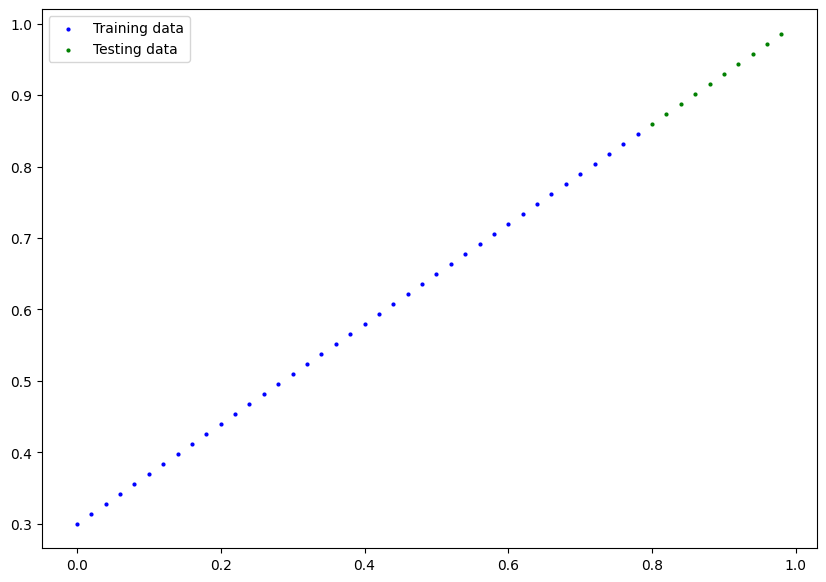

In [14]:
plot_predictions()

In [15]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [16]:
torch.manual_seed(47)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.8939]])),
              ('linear_layer.bias', tensor([-0.9002]))]))

In [17]:
next(model_1.parameters()).device
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [18]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [19]:
torch.manual_seed(47)

epoches = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epoches):
    ## TRAINING
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ## TESTING
    model_1.eval()

    with torch.inference_mode():
        # 1. foward pass
        test_pred = model_1(X_test)

        # 2. calculate loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 1.8217837810516357 | Test loss: 2.6052653789520264
Epoch: 100 | Train loss: 0.6696848273277283 | Test loss: 1.2581665515899658
Epoch: 200 | Train loss: 0.17611686885356903 | Test loss: 0.45683518052101135
Epoch: 300 | Train loss: 0.13879908621311188 | Test loss: 0.3236912786960602
Epoch: 400 | Train loss: 0.10445411503314972 | Test loss: 0.24371559917926788
Epoch: 500 | Train loss: 0.07011260092258453 | Test loss: 0.16305148601531982
Epoch: 600 | Train loss: 0.0357690304517746 | Test loss: 0.08307363092899323
Epoch: 700 | Train loss: 0.0030151575338095427 | Test loss: 0.00520517211407423
Epoch: 800 | Train loss: 0.003993733786046505 | Test loss: 0.00520517211407423
Epoch: 900 | Train loss: 0.003993733786046505 | Test loss: 0.00520517211407423


In [20]:
from pprint import pprint
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())

print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6915]])),
             ('linear_layer.bias', tensor([0.2993]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [21]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8525],
        [0.8663],
        [0.8802],
        [0.8940],
        [0.9078],
        [0.9216],
        [0.9355],
        [0.9493],
        [0.9631],
        [0.9770]])

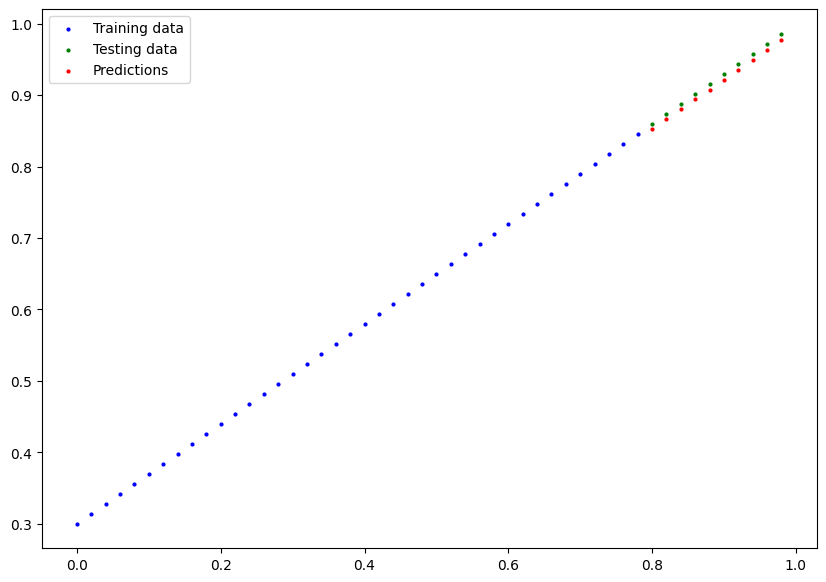

In [22]:
plot_predictions(predictions=y_preds.cpu())

In [61]:
# Save model

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [62]:
# load model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device=device)

print(f"Loaded model: \n{loaded_model_1}")
print(f"Model on device: \n{next(loaded_model_1.parameters()).device}")

Loaded model: 
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device: 
cpu


In [64]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])